In [3]:
import pandas as pd

file_path = 'Combined_global_ETFs.csv'
df = pd.read_csv(file_path)

df.head()


,Date,Open,High,Low,Close,Volume,Ticker,Country
0,2015-01-02,61.17,61.1700,60.49,60.63,509525,AAXJ,AsiaPacific
1,2015-01-02,57.08,57.1999,56.66,56.73,566669,VPL,AsiaPacific
2,2015-01-02,29.35,29.3500,29.35,29.35,0,VCN.TO,Canada
3,2015-01-02,23.18,23.3700,23.17,23.37,201842,XIC.TO,Canada
4,2015-01-02,21.54,21.6800,21.50,21.68,4251200,XIU.TO,Canada


In [4]:
#Counting fully duplicated rows
full_duplicate_count = df.duplicated().sum()

#Counting partial duplicates based on Date, Ticker, Country
partial_duplicate_count = df.duplicated(subset=['Date', 'Ticker', 'Country']).sum()

full_duplicate_count, partial_duplicate_count

(np.int64(0), np.int64(0))

In [5]:
#Checking the summary before cleaning
summary_before = {
    "Initial Shape": df.shape,
    "Missing Values": df.isnull().sum(),
    "Duplicate Rows": df.duplicated(subset=['Date', 'Ticker', 'Country']).sum()
}
summary_before

{'Initial Shape': (45994, 8),
 'Missing Values': Date       0
 Open       0
 High       0
 Low        0
 Close      0
 Volume     0
 Ticker     0
 Country    0
 dtype: int64,
 'Duplicate Rows': np.int64(0)}

In [22]:
# non-null counts
initial_non_null_counts = df.count()
initial_non_null_counts

,0
Date,45994
Open,45994
High,45994
Low,45994
Close,45994
Volume,45994
Ticker,45994
Country,45994


In [21]:
#Converting Date column with coercion
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Volume,int64
Ticker,object
Country,object


In [7]:
#Checking if there is any invalid values for open, close and volume columns
invalid_open_high = df[df['Open'] > df['High']]
invalid_low_high = df[df['Low'] > df['High']]
invalid_volume = df[df['Volume'] < 0]

#Summary of invalid value counts
invalid_summary = pd.DataFrame({
    'Invalid Open > High': [len(invalid_open_high)],
    'Invalid Low > High': [len(invalid_low_high)],
    'Invalid Volume < 0': [len(invalid_volume)]
})

invalid_summary

,Invalid Open > High,Invalid Low > High,Invalid Volume < 0
0,0,0,0


In [8]:
#Previewing unique ticker symbols to check if standardizing is needed or not
unique_tickers = df['Ticker'].dropna().unique()
unique_tickers

array(['AAXJ', 'VPL', 'VCN.TO', 'XIC.TO', 'XIU.TO', 'ZEB.TO', 'IEUR',
       'VGK', 'ACWI', 'VT', 'QQQ', 'SPY', 'VTI', 'XLE', 'XLF', 'XLK',
       'XLV', 'VEQT.TO'], dtype=object)

In [26]:
#Checking the outliers
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

#First, calculating IQR for outlier detection
outlier_summary = []
outlier_summary_explained = []


for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_below = df[df[col] < lower_bound][col].count()
    outliers_above = df[df[col] > upper_bound][col].count()

    outlier_summary.append({
        'Column': col,
        'Q1 (25%)': Q1,
        'Q3 (75%)': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Below': outliers_below,
        'Outliers Above': outliers_above,
        'Total Outliers': outliers_below + outliers_above
    })

    outlier_summary_explained.append({
        'Column': col,
        'Normal Range (Q1 to Q3)': f"Between {Q1:.2f} and {Q3:.2f}",
        'Outliers': f"{outliers_above:,} values above {upper_bound:.2f}"
    })

#Then converting to DataFrame
outlier_summary_df = pd.DataFrame(outlier_summary)
outlier_summary_explained = pd.DataFrame(outlier_summary_explained)

In [30]:
outlier_summary_df

,Column,Q1 (25%),Q3 (75%),IQR,Lower Bound,Upper Bound,Outliers Below,Outliers Above,Total Outliers
0,Open,35.761500,9.997750e+01,6.421600e+01,-6.056250e+01,1.963015e+02,0,5267,5267
1,High,35.930000,1.006200e+02,6.469000e+01,-6.110500e+01,1.976550e+02,0,5272,5272
2,Low,35.542075,9.926000e+01,6.371793e+01,-6.003481e+01,1.948369e+02,0,5260,5260
3,Close,35.780000,9.998000e+01,6.420000e+01,-6.052000e+01,1.962800e+02,0,5266,5266
4,Volume,470700.000000,1.153414e+07,1.106344e+07,-1.612445e+07,2.812929e+07,0,7349,7349


In [31]:
outlier_summary_explained


,Column,Normal Range (Q1 to Q3),Outliers
0,Open,Between 35.76 and 99.98,"5,267 values above 196.30"
1,High,Between 35.93 and 100.62,"5,272 values above 197.66"
2,Low,Between 35.54 and 99.26,"5,260 values above 194.84"
3,Close,Between 35.78 and 99.98,"5,266 values above 196.28"
4,Volume,Between 470700.00 and 11534135.00,"7,349 values above 28129287.50"


Most of your data for prices (Open, High, Low, Close) lies between $35 and $100.

But you have thousands of data points where prices are way above $190, which are flagged as outliers.

Similarly, most Volume values are below 11 million, but 7,349 values go way beyond 28 million, which are outliers.

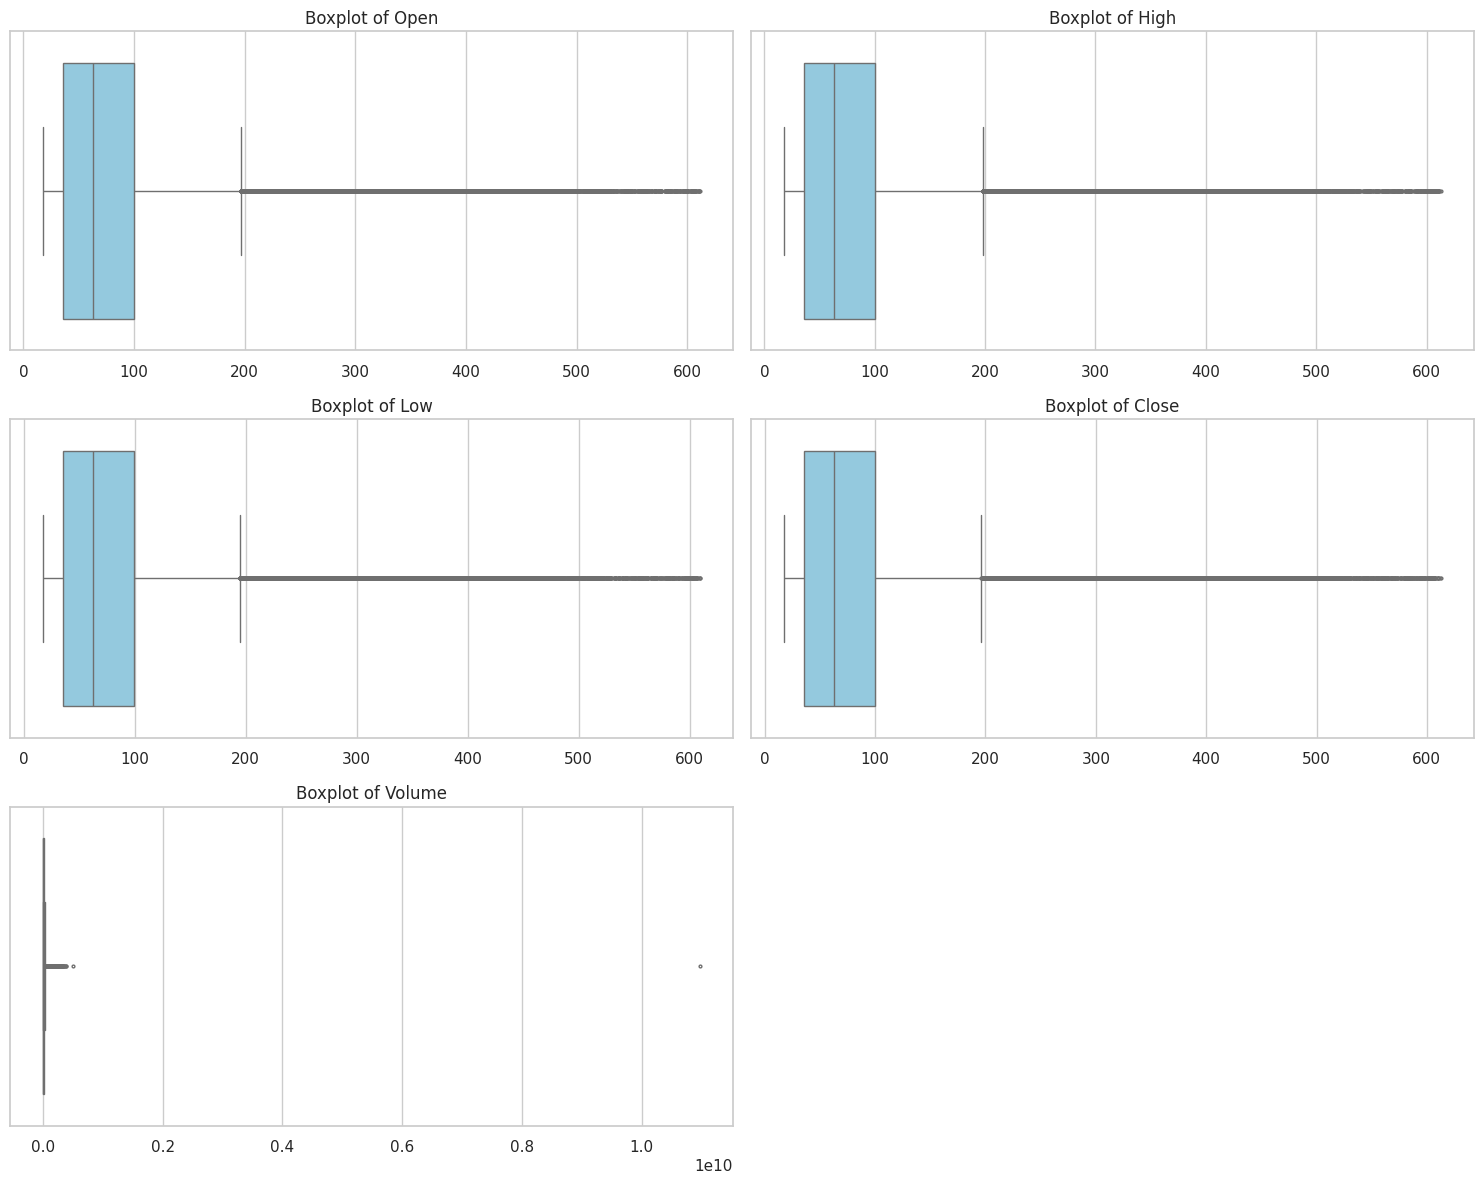

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

#Plotting boxplots for each numeric column to visualize outliers
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue', fliersize=2)
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('')

#Removing empty subplot if odd number of plots
if len(numeric_cols) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()
